# Parsing Raw Affymetrix CEL files

We define a function, which can be used to rip out probe intensity data from Affymetrix CEL files. Only CEL file version 4 is supported (the binary version). This is suitable for the Human Exon chip. Probe intensity data is written into numpy arrays, to enable easy analysis.

Each CEL file contains 3 data points for each probe:

`(average pixel intensity, standard deviation of pixel intensity, number of pixels)`

This means that the data for the first 10 probes looks similar to:

    (7326.0, 875.0999755859375,  9)
    (162.0,  34.099998474121094, 9)
    (6933.0, 1001.0,             9)
    (224.0,  36.400001525878906, 9)
    (54.0,   6.0,                9)
    (247.0,  23.5,               9)
    (210.0,  18.299999237060547, 9)
    (207.0,  28.200000762939453, 9)
    (1147.0, 188.1999969482422,  9)
    (221.0,  24.200000762939453, 9)

the function returns a tuple of numpy arrays: `(intensities, deviations, pixels)`

In [1]:
import sys
import struct
import numpy

def readCEL4(celfile):
    numbers = ["magic", "version", "columns", "rows", "cellNo", "headerLen"]
    numbersMap = {}
    headerMap = {}
    with open(celfile, "rb") as f:

        for name in numbers:
            numbersMap[name] = struct.unpack('<i', f.read(4))[0]
        char = f.read(numbersMap["headerLen"])
        header = char.decode("ascii", "ignore")
        for header in header.split("\n"):
            if "=" in header:
                header = header.split("=")
                headerMap[header[0]] = header[1]

        char = b'\x00'
        safetyValve = 10**4
        for i in range(10**4):
            char = f.read(1)
            if char == b'\x04':
                break
            if i == safetyValve:
                raise(ValueError("Parse Error"))

        padding = f.read(15)

        structa = struct.Struct("< f f h")

        structSize = 10

        length = numbersMap["cellNo"]

        intensities = numpy.empty(length, dtype=float)
        deviations = numpy.empty(length, dtype=float)
        pixels = numpy.empty(length, dtype=int)

        b = f.read(structSize * length)
        for i in range(length):
            binaryFragment = b[i * structSize : (i + 1) * structSize]
            intensity, deviation, pixelcount = structa.unpack(binaryFragment)
            intensities[i] = intensity
            deviations[i] = deviation
            pixels[i] = pixelcount

    return intensities, deviations, pixels

In [2]:
import os, os.path
p = os.path.join
CELDir = p("CELfiles", "blood")
CELfiles = os.listdir(CELDir)

intensities, stdevs, pixels = readCEL4(p(CELDir, CELfiles[0]))

6553600
30152.0


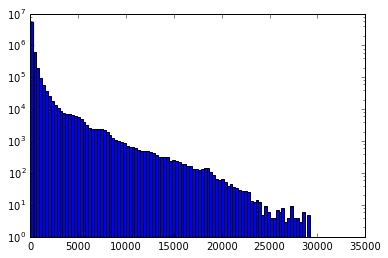

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

print(len(intensities))

print(max(intensities))

plt.hist(intensities, bins=100, log=1)

plt.show()

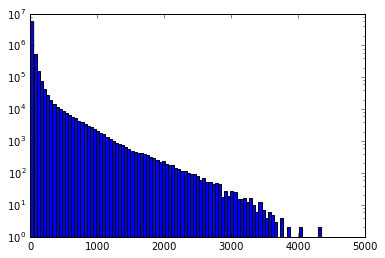

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(stdevs, bins=100, log=1)

plt.show()

In [5]:
plt.scatter(intensities, stdevs) ``

plt.show()

SyntaxError: invalid syntax (<ipython-input-5-54613eddcce8>, line 1)

In [ ]:
zip(intensities, stdevs)